In [134]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from torchvision.datasets import MNIST

In [135]:
dataset = MNIST("dataset", download=True, transform=transforms.ToTensor())

RuntimeError: Error downloading train-images-idx3-ubyte.gz:
Tried https://ossci-datasets.s3.amazonaws.com/mnist/, got:
<urlopen error [Errno 8] nodename nor servname provided, or not known>
Tried http://yann.lecun.com/exdb/mnist/, got:
<urlopen error [Errno 8] nodename nor servname provided, or not known>


In [24]:
img = Image.open("./test_img.jpg")
img = np.array(img)

img_tensor = torch.from_numpy(img).float()[None, :, :, :] / 255

def show_np(img):
    plt.imshow(img)
    plt.axis('off')

def show_torch_tensor(img):
    img = img.numpy()

    if img.ndim == 4:
        img = img[0]

    plt.imshow(img)
    plt.axis('off')

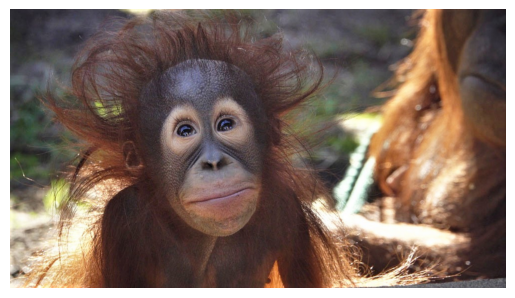

In [25]:
show_torch_tensor(img_tensor)

# Forward Process

in forward process we want to implement the markov chain tbar takes input $x_t$ and produce corrupted input $X_{t+1}$ as:

$$
q(x_{t+1} | x_t) = \mathcal{N(x_t, \sqrt{1-\beta_{t}} \cdot x_{t-1}, \beta_t \mathbf{I})}
$$

we could also introduce:

$$
\alpha_t = 1 - \beta_t
$$
and
$$
\bar{\alpha_t} = \prod_{s = 1}^t \alpha_s
$$

then

$$
q(x_{t+1} | x_t) = \mathbf{N(x_t, \sqrt{\bar{\alpha_t}} \cdot x_{t-1}, (1 - \bar{\alpha_t}) \mathbf{I})}
$$

## define params

In [103]:
num_steps = 100
beta_start = 1e-4
beta_end = 1e-1

## Define alpha

In [104]:
betas = torch.linspace(beta_start, beta_end, num_steps)

alphas = 1 - betas

alphas_compound = torch.cumprod(alphas, dim=0)

## Implement add_noise function

x: torch Tensor of shape [batch_size, Img_h, Img_w, Img_c]

t: torch Scalar



1. take the $\bar{a_t}$ for index $t$
2. find $1-\bar{a_t}$
3. compute $x \cdot \sqrt{\bar{a_t}} + \sqrt{1-\bar{a_t}} \cdot \epsilon $

In [122]:
def add_noise(x, t):
    sqrt_a_compound = torch.sqrt(alphas_compound[t]).unsqueeze(0)[:, None, None, None]
    sqrt_one_minus_a_compound = torch.sqrt(1 - alphas_compound[t]).unsqueeze(0)[:, None, None, None]

    e = torch.randn_like(x)

    return x * sqrt_a_compound + sqrt_one_minus_a_compound * e

img_noised = add_noise(img_tensor, 1)

## Implement Step function


x: torch Tensor of shape [batch_size, Img_h, Img_w, Img_c]

pred_noise: torch Tensor of shape [batch_size, Img_h, Img_w, Img_c]

t: torch Scalar


Let $\epsilon$ be the predicted noise


1. get formula terms
2. sample $z := \mathcal{N}(0,1)$ if $t > 1$ else $z := 0$
3. compute
$$
\frac{1}{\sqrt{\bar{a_t}}} (x_t - \frac{1 - \bar{a_t}}{\sqrt{1 - \bar{a_t}}} \epsilon) + \sqrt{\beta_t} \cdot z
$$

In [129]:
def step(x, pred_noise, t):
    sqrt_a_compound = torch.sqrt(alphas_compound[t]).unsqueeze(0)[:, None, None, None]
    one_minus_a = 1 - alphas[t][:, None, None, None]
    one_minus_a_compound = 1 - alphas_compound[t][:, None, None, None]
    sqrt_one_minus_a_compound = torch.sqrt(one_minus_a_compound)
    sqrt_beta = torch.sqrt(betas[t]).unsqueeze(0)[:, None, None, None]

    if t == 0:
        z = torch.zeros_like(x)
    else:
        z = torch.randn_like(x)

    return 1 / sqrt_a_compound * ( x - (one_minus_a / sqrt_one_minus_a_compound) * pred_noise ) + sqrt_beta * z

In [125]:
img_noised = add_noise(img_tensor, 80)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.960743..4.970816].


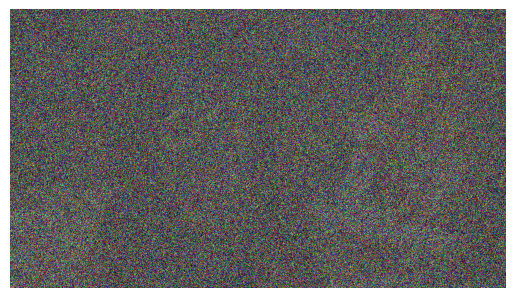

In [126]:
show_torch_tensor(img_noised)

In [ ]:
class